In [1]:
from google.colab import files
uploaded = files.upload()

Saving World_MerchantFleet.csv to World_MerchantFleet.csv


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    "World_MerchantFleet.csv",
    low_memory=False
)

print("Shape:", df.shape)
df.head()

Shape: (62228, 23)


,Year,Economy,Economy Label,ShipType,ShipType Label,Dead weight tons in thousands,Dead weight tons in thousands Footnote,Dead weight tons in thousands Missing value,Percentage of total world,Percentage of total world Footnote,...,Percentage of total fleet Missing value,Number of ships,Number of ships Footnote,Number of ships Missing value,Gross Tonnage in thousands,Gross Tonnage in thousands Footnote,Gross Tonnage in thousands Missing value,Average age of vessels (years),Average age of vessels (years) Footnote,Average age of vessels (years) Missing value
0,1980,0000,World,0,Total fleet,672192.465,NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected
1,1980,0000,World,1,Oil tankers,337945.534,NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected
2,1980,0000,World,2,Bulk carriers,181880.282,NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected
3,1980,0000,World,3,General cargo,112840.897,NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected
4,1980,0000,World,4,Container ships,10290.114,NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected,NaN,NaN,No value reported or collected


In [3]:
df.columns = df.columns.str.strip()
print(df.columns.tolist())

['Year', 'Economy', 'Economy Label', 'ShipType', 'ShipType Label', 'Dead weight tons in thousands', 'Dead weight tons in thousands Footnote', 'Dead weight tons in thousands Missing value', 'Percentage of total world', 'Percentage of total world Footnote', 'Percentage of total world Missing value', 'Percentage of total fleet', 'Percentage of total fleet Footnote', 'Percentage of total fleet Missing value', 'Number of ships', 'Number of ships Footnote', 'Number of ships Missing value', 'Gross Tonnage in thousands', 'Gross Tonnage in thousands Footnote', 'Gross Tonnage in thousands Missing value', 'Average age of vessels (years)', 'Average age of vessels (years) Footnote', 'Average age of vessels (years) Missing value']


In [4]:
drop_cols = [c for c in df.columns if "Missing" in c or "Footnote" in c]
df = df.drop(columns=drop_cols, errors="ignore")

print("After drop:", df.shape)

After drop: (62228, 11)


In [5]:
df.columns

Index(['Year', 'Economy', 'Economy Label', 'ShipType', 'ShipType Label',
       'Dead weight tons in thousands', 'Percentage of total world',
       'Percentage of total fleet', 'Number of ships',
       'Gross Tonnage in thousands', 'Average age of vessels (years)'],
      dtype='object')

In [6]:
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.dropna(subset=["Year"])
df["Year"] = df["Year"].astype(int)

In [7]:
cols_to_drop_manual = [
    "Percentage of total world",
    "Percentage of total fleet",
    "Number of ships",
    "Gross Tonnage in thousands",
    "Average age of vessels (years)"
]

df = df.drop(columns=cols_to_drop_manual, errors="ignore")

print("After removing extra indicators:", df.shape)

After removing extra indicators: (62228, 6)


In [8]:
# STEP 7: Remove rows with missing essential values
# =========================================================

# Ensure 'Dead weight tons in thousands' is numeric and clean it
df["Dead weight tons in thousands"] = pd.to_numeric(df["Dead weight tons in thousands"], errors="coerce")
df = df.dropna(subset=["Dead weight tons in thousands"]) # Drop rows where this essential column is NaN
df = df[df["Dead weight tons in thousands"] > 0] # Keep only positive values if applicable

# Create the 'DWT_million' column
df["DWT_million"] = df["Dead weight tons in thousands"] / 1000

# Now, remove rows with missing essential values, including the newly created 'DWT_million'
df = df.dropna(subset=[
    "DWT_million",
    "ShipType Label",
    "Economy Label"
])

In [9]:
# STEP 8: Filter WORLD data only
# =========================================================
df_world = df[df["Economy Label"] == "World"].copy()

print("World-only shape:", df_world.shape)

World-only shape: (276, 7)


In [10]:
# STEP 9: Build clean yearly time series (per ShipType)
# =========================================================
def build_world_series(df_world, ship_type,
                       start_year=1980,
                       end_year=2025):
    """
    Returns a clean yearly time series of DWT (million tons)
    for a selected ship type.
    """
    d = df_world[df_world["ShipType Label"] == ship_type].copy()
    d = d.sort_values("Year")

    y = pd.Series(
        d["DWT_million"].values,
        index=pd.to_datetime(d["Year"], format="%Y")
    ).asfreq("YS")

    # Restrict years
    y = y[(y.index.year >= start_year) & (y.index.year <= end_year)]

    # Handle missing values
    y = y.interpolate(method="time").ffill().bfill()

    return y

In [11]:
# STEP 10: Example usage
# =========================================================
example_ship = "General cargo"

y_general_cargo = build_world_series(df_world, example_ship)

print(example_ship)
print("Years:", y_general_cargo.index.year.min(),
      "→", y_general_cargo.index.year.max())
print("Length:", len(y_general_cargo))
print(y_general_cargo.head())

General cargo
Years: 1980 → 2025
Length: 46
Year
1980-01-01    112.840897
1981-01-01    114.832851
1982-01-01    113.293837
1983-01-01    113.269092
1984-01-01    111.863049
Freq: YS-JAN, dtype: float64


In [12]:
df.to_csv("World_MerchantFleet_CLEAN.csv", index=False)
df_world.to_csv("World_MerchantFleet_WORLD.csv", index=False)

print("Files saved in current directory")

Files saved in current directory


In [13]:
df.to_csv("World_MerchantFleet_CLEAN.csv", index=False)



In [14]:
from google.colab import files
files.download("World_MerchantFleet_CLEAN.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import pandas as pd
import numpy as np

df = pd.read_csv("World_MerchantFleet.csv")

df = df[df["Economy Label"] == "World"].copy()

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.dropna(subset=["Year"])
df["Year"] = df["Year"].astype(int)

df = df[(df["Year"] >= 1980) & (df["Year"] <= 2020)]

df["Dead weight tons in thousands"] = pd.to_numeric(df["Dead weight tons in thousands"], errors="coerce")
df = df.dropna(subset=["Dead weight tons in thousands"])
df = df[df["Dead weight tons in thousands"] > 0]

df["DWT_million"] = df["Dead weight tons in thousands"] / 1000


/tmp/ipython-input-3119006878.py:4: DtypeWarning: Columns (15,18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("World_MerchantFleet.csv")



=== FINAL XGBOOST RESULTS (y.diff + crisis_flag) ===
RMSE_train: 39.83
RMSE_test : 32.95
PE_train  : 4.80%
PE_test   : 1.51%
R²_train  : 0.973
R²_test   : 0.945


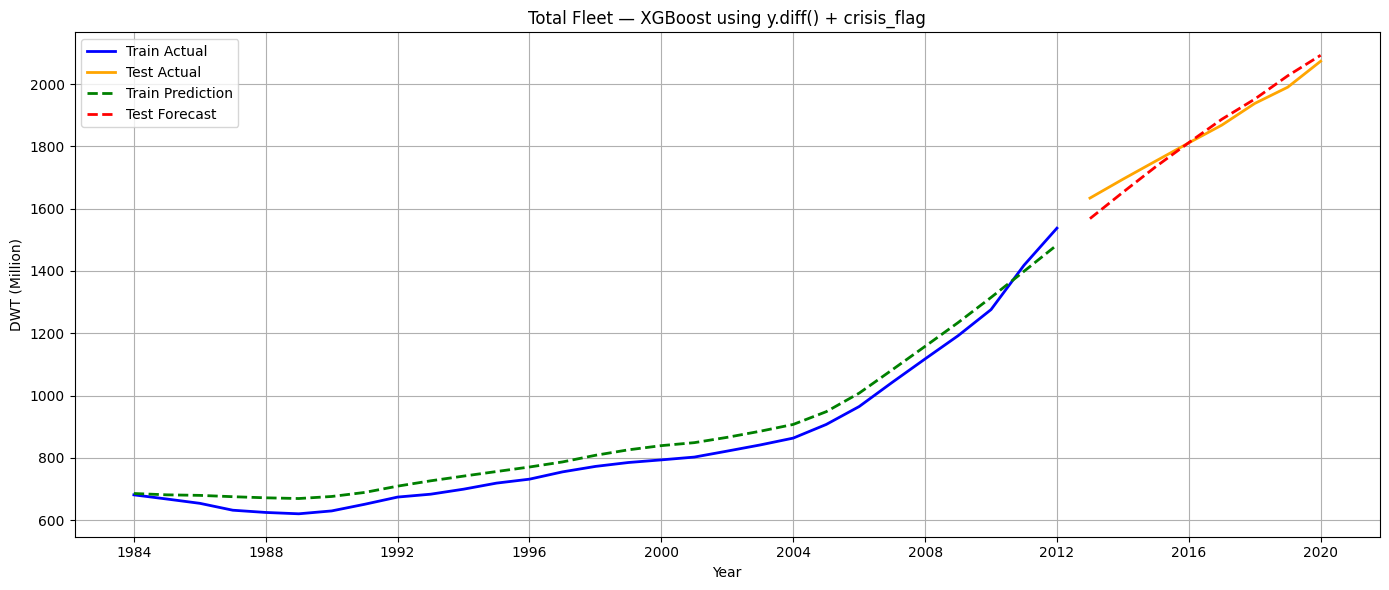

In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# =========================================================
# STEP 0: Load & prepare time series (Total fleet)
# =========================================================
ship = "Total fleet"
dship = df[df["ShipType Label"] == ship].sort_values("Year")

y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(dship["Year"], format="%Y")
).asfreq("YS")

y = y[(y.index.year >= 1980) & (y.index.year <= 2020)]
y = y.interpolate(method="time")

# Use yearly difference
y_diff = y.diff().dropna()

# =========================================================
# STEP 1: Feature engineering on y.diff()
# =========================================================
def create_features(y):
    df_feat = pd.DataFrame({"y": y})

    # Basic lags (MOST IMPORTANT)
    df_feat["lag_1"] = df_feat["y"].shift(1)
    df_feat["lag_2"] = df_feat["y"].shift(2)

    # Rolling statistics
    df_feat["roll_mean_3"] = df_feat["y"].shift(1).rolling(3).mean()
    df_feat["roll_std_3"]  = df_feat["y"].shift(1).rolling(3).std()

    # Crisis indicator (no deletion of years)
    crisis_years = [2008, 2009, 2010]
    df_feat["crisis_flag"] = df_feat.index.year.isin(crisis_years).astype(int)

    # Time feature (helps long-term trend)
    df_feat["year_norm"] = (
        (df_feat.index.year - df_feat.index.year.min()) /
        (df_feat.index.year.max() - df_feat.index.year.min())
    )

    df_feat.dropna(inplace=True)
    return df_feat

df_feat = create_features(y_diff)
X = df_feat.drop(columns=["y"])
y_target = df_feat["y"]

# =========================================================
# STEP 2: Time-based train / test split (NO SHUFFLE)
# =========================================================
split_index = int(len(X) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]
y_train = y_target.iloc[:split_index]
y_test  = y_target.iloc[split_index:]

# =========================================================
# STEP 3: Train XGBoost (stable + anti-overfitting)
# =========================================================
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    learning_rate=0.02,
    max_depth=2,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=5,
    reg_lambda=10,
    random_state=42
)


model.fit(X_train, y_train)

# =========================================================
# STEP 4: Predict y.diff() and reconstruct original y
# =========================================================
# Predict differences
y_pred_train_diff = model.predict(X_train)
y_pred_test_diff  = model.predict(X_test)

# Rebuild TRAIN
first_train_val = y.loc[X_train.index[0] - pd.DateOffset(years=1)]
y_pred_train = pd.Series(
    first_train_val + np.cumsum(y_pred_train_diff),
    index=X_train.index
)

# Rebuild TEST (continue from last TRAIN prediction)
last_train_val = y_pred_train.iloc[-1]
y_pred_test = pd.Series(
    last_train_val + np.cumsum(y_pred_test_diff),
    index=X_test.index
)

# Actual values
y_train_actual = y.loc[X_train.index]
y_test_actual  = y.loc[X_test.index]

# =========================================================
# STEP 5: Evaluation
# =========================================================
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))

pe_train = np.mean(np.abs((y_train_actual - y_pred_train) / y_train_actual)) * 100
pe_test  = np.mean(np.abs((y_test_actual - y_pred_test) / y_test_actual)) * 100

r2_train = r2_score(y_train_actual, y_pred_train)
r2_test  = r2_score(y_test_actual, y_pred_test)

print("\n=== FINAL XGBOOST RESULTS (y.diff + crisis_flag) ===")
print(f"RMSE_train: {rmse_train:.2f}")
print(f"RMSE_test : {rmse_test:.2f}")
print(f"PE_train  : {pe_train:.2f}%")
print(f"PE_test   : {pe_test:.2f}%")
print(f"R²_train  : {r2_train:.3f}")
print(f"R²_test   : {r2_test:.3f}")

# =========================================================
# STEP 6: Plot (NO DISCONTINUITY)
# =========================================================
plt.figure(figsize=(14, 6))

plt.plot(y_train_actual, label="Train Actual", color="blue", linewidth=2)
plt.plot(y_test_actual,  label="Test Actual",  color="orange", linewidth=2)

plt.plot(y_pred_train, label="Train Prediction", color="green", linestyle="--", linewidth=2)
plt.plot(y_pred_test,  label="Test Forecast",    color="red",   linestyle="--", linewidth=2)

plt.title("Total Fleet — XGBoost using y.diff() + crisis_flag")
plt.xlabel("Year")
plt.ylabel("DWT (Million)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

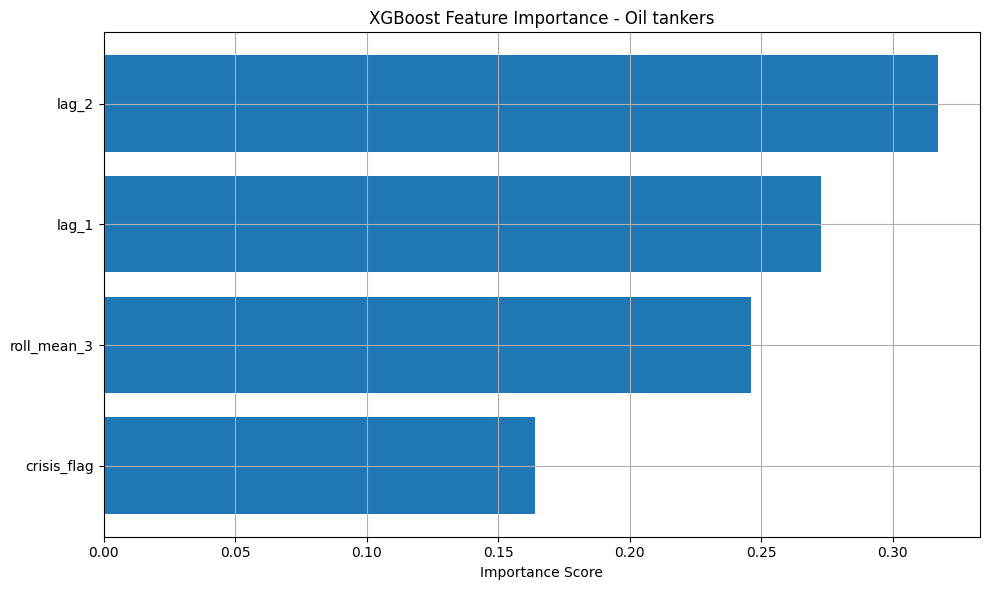


=== XGBOOST RESULTS (Oil tankers) ===
RMSE_train: 24.96
RMSE_test : 22.46
PE_train  : 8.11%
PE_test   : 3.05%
R²_train  : 0.864
R²_test   : 0.735


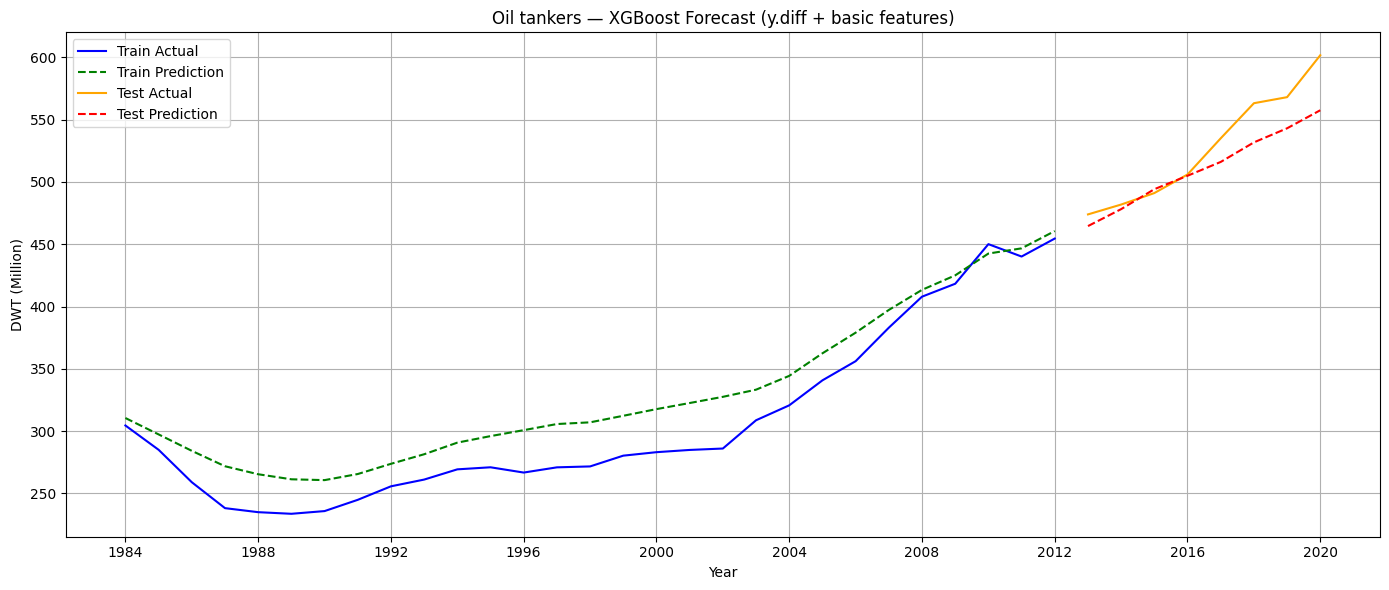

In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt





ship = "Oil tankers"
dship = df[df["ShipType Label"] == ship].sort_values("Year")


y = pd.Series(dship["DWT_million"].values, index=pd.to_datetime(dship["Year"], format="%Y")).asfreq("YS")
y = y.interpolate(method="time")
crisis_years = [2008, 2009, 2015, 2020]
df_feat["crisis_flag"] = df_feat.index.year.isin(crisis_years).astype(int)

y_diff = y.diff().dropna()


def create_features(y):
    df_feat = pd.DataFrame({"y": y})
    df_feat["lag_1"] = df_feat["y"].shift(1)
    df_feat["lag_2"] = df_feat["y"].shift(2)
    df_feat["roll_mean_3"] = df_feat["y"].shift(1).rolling(3).mean()
    crisis_years = [2011, 2012, 2013]
    df_feat["crisis_flag"] = df_feat.index.year.isin(crisis_years).astype(int)
    df_feat.dropna(inplace=True)
    return df_feat

df_feat = create_features(y_diff)
X = df_feat.drop(columns=["y"])
y_target = df_feat["y"]


split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y_target.iloc[:split_index], y_target.iloc[split_index:]


model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    learning_rate=0.02,
    max_depth=2,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=5,
    reg_lambda=10,
    random_state=42
)

model.fit(X_train, y_train)


train_start = y.loc[X_train.index[0] - pd.DateOffset(years=1)]
y_pred_train = pd.Series(train_start + np.cumsum(model.predict(X_train)), index=X_train.index)

last_train_val = y_pred_train.iloc[-1]
y_pred_test = pd.Series(last_train_val + np.cumsum(model.predict(X_test)), index=X_test.index)


y_train_actual = y.loc[X_train.index]
y_test_actual = y.loc[X_test.index]

# === Feature Importance calculation
importances = model.feature_importances_
features = X_train.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance - Oil tankers")
plt.xlabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()


rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))
pe_train = np.mean(np.abs((y_train_actual - y_pred_train) / y_train_actual)) * 100
pe_test = np.mean(np.abs((y_test_actual - y_pred_test) / y_test_actual)) * 100
r2_train = r2_score(y_train_actual, y_pred_train)
r2_test = r2_score(y_test_actual, y_pred_test)


print("\n=== XGBOOST RESULTS (Oil tankers) ===")
print(f"RMSE_train: {rmse_train:.2f}")
print(f"RMSE_test : {rmse_test:.2f}")
print(f"PE_train  : {pe_train:.2f}%")
print(f"PE_test   : {pe_test:.2f}%")
print(f"R²_train  : {r2_train:.3f}")
print(f"R²_test   : {r2_test:.3f}")

# === الرسم
plt.figure(figsize=(14,6))
plt.plot(y_train_actual, label="Train Actual", color="blue")
plt.plot(y_pred_train, label="Train Prediction", linestyle="--", color="green")
plt.plot(y_test_actual, label="Test Actual", color="orange")
plt.plot(y_pred_test, label="Test Prediction", linestyle="--", color="red")
plt.title(f"{ship} — XGBoost Forecast (y.diff + basic features)")
plt.xlabel("Year")
plt.ylabel("DWT (Million)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

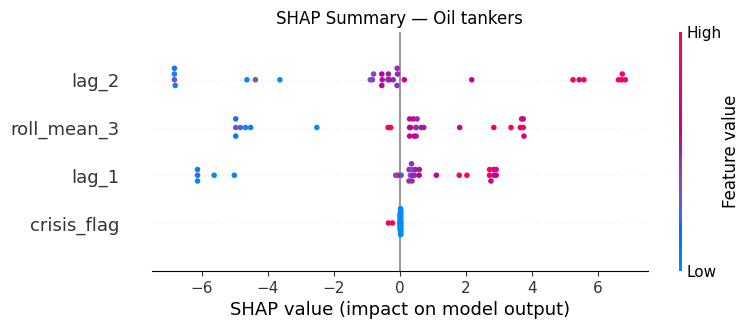

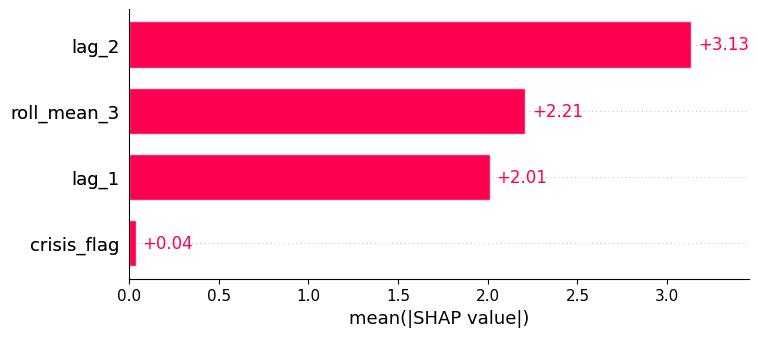

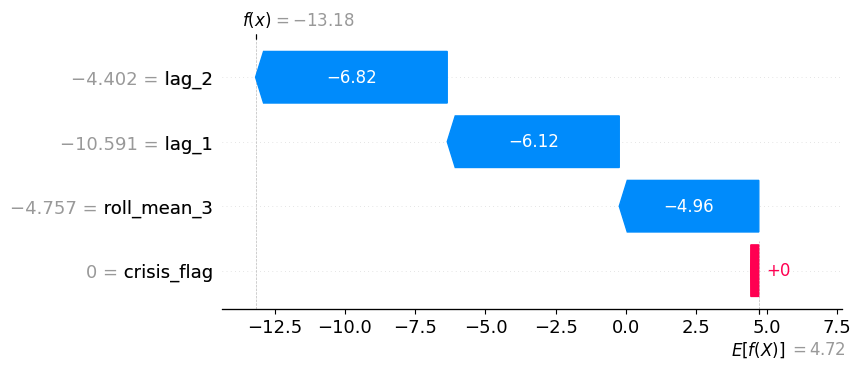

In [18]:
import shap
import matplotlib.pyplot as plt

# === SHAP EXPLAINER
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# === 1. Beeswarm Plot
plt.title("SHAP Summary — Oil tankers")
shap.plots.beeswarm(shap_values, max_display=10)

# === 2. Bar Plot
shap.plots.bar(shap_values, max_display=10)


shap.plots.waterfall(shap_values[0])

# === 4. Force Plot

shap.plots.force(shap_values[0])




=== FINAL XGBOOST RESULTS (Bulk carriers, corrected) ===
RMSE_train: 17.69
RMSE_test : 31.92
PE_train  : 2.96%
PE_test   : 3.48%
R²_train  : 0.968
R²_test   : 0.696


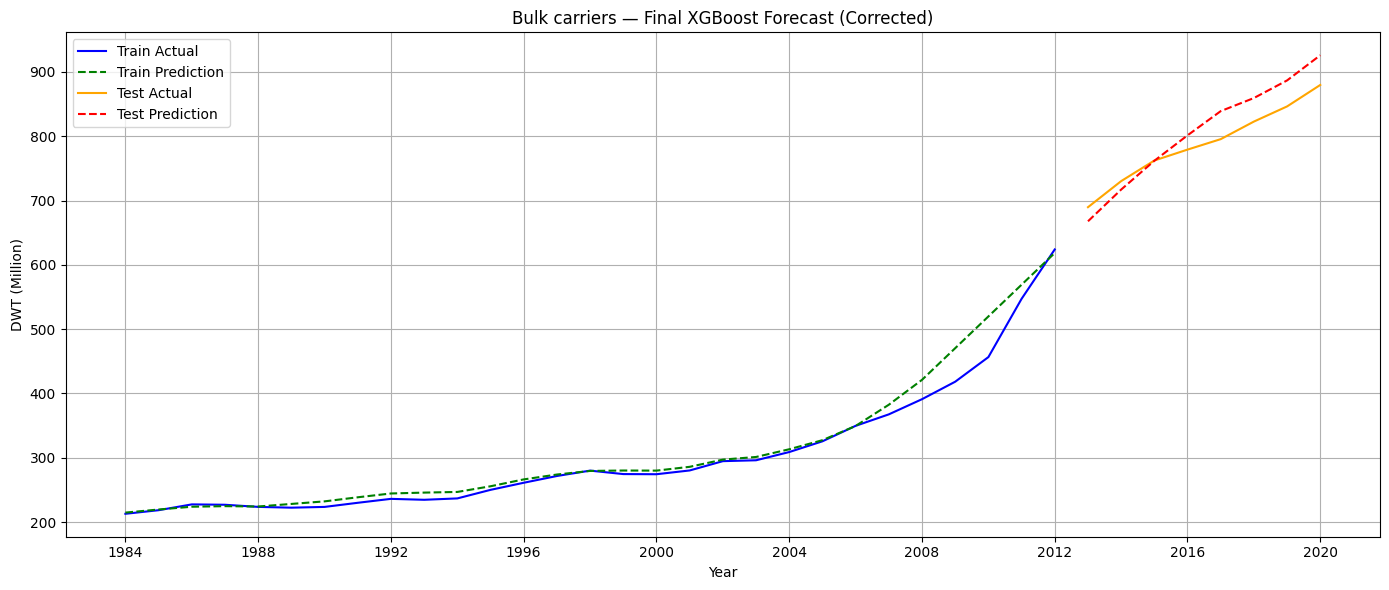

In [19]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


ship = "Bulk carriers"
dship = df[df["ShipType Label"] == ship].sort_values("Year")


y = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(dship["Year"], format="%Y")
).asfreq("YS").interpolate(method="time")

y_diff = y.diff().dropna()


def create_features(y, y_original):
    df_feat = pd.DataFrame({"y": y})

    # Lags
    df_feat["lag_1"] = df_feat["y"].shift(1)
    df_feat["lag_2"] = df_feat["y"].shift(2)

    # Rolling features
    df_feat["roll_mean_3"] = df_feat["y"].shift(1).rolling(3).mean()

    # Time
    df_feat["year"] = df_feat.index.year

    # Growth
    growth = y_original.pct_change().shift(1)
    df_feat["growth_rate"] = (growth - growth.mean()) / growth.std()

    df_feat.dropna(inplace=True)
    return df_feat

df_feat = create_features(y_diff, y)
X = df_feat.drop(columns=["y"])
y_target = df_feat["y"]

# === STEP 4: Train/Test Split
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y_target.iloc[:split_index], y_target.iloc[split_index:]

# === STEP 5: XGBoost Model
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    learning_rate=0.03,
    max_depth=3,
    min_child_weight=5,
    n_estimators=300,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=3,
    reg_lambda=8,
    random_state=42
)
model.fit(X_train, y_train)


train_start = y.loc[X_train.index[0] - pd.DateOffset(years=1)]
y_pred_train = pd.Series(train_start + np.cumsum(model.predict(X_train)), index=X_train.index)
y_pred_test = pd.Series(y_pred_train.iloc[-1] + np.cumsum(model.predict(X_test)), index=X_test.index)


y_train_actual = y.loc[X_train.index]
y_test_actual = y.loc[X_test.index]


rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test_actual,  y_pred_test))
pe_train = np.mean(np.abs((y_train_actual - y_pred_train) / y_train_actual)) * 100
pe_test  = np.mean(np.abs((y_test_actual  - y_pred_test)  / y_test_actual))  * 100
r2_train = r2_score(y_train_actual, y_pred_train)
r2_test  = r2_score(y_test_actual,  y_pred_test)


print("\n=== FINAL XGBOOST RESULTS (Bulk carriers, corrected) ===")
print(f"RMSE_train: {rmse_train:.2f}")
print(f"RMSE_test : {rmse_test:.2f}")
print(f"PE_train  : {pe_train:.2f}%")
print(f"PE_test   : {pe_test:.2f}%")
print(f"R²_train  : {r2_train:.3f}")
print(f"R²_test   : {r2_test:.3f}")


plt.figure(figsize=(14,6))
plt.plot(y_train_actual, label="Train Actual", color="blue")
plt.plot(y_pred_train, "--", label="Train Prediction", color="green")
plt.plot(y_test_actual, label="Test Actual", color="orange")
plt.plot(y_pred_test, "--", label="Test Prediction", color="red")
plt.title(f"{ship} — Final XGBoost Forecast (Corrected)")
plt.xlabel("Year")
plt.ylabel("DWT (Million)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

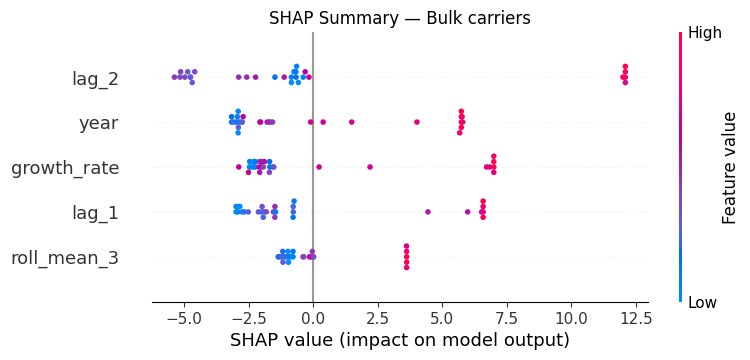

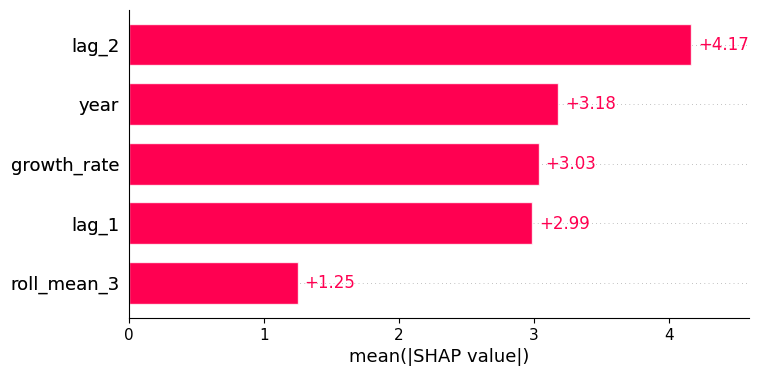

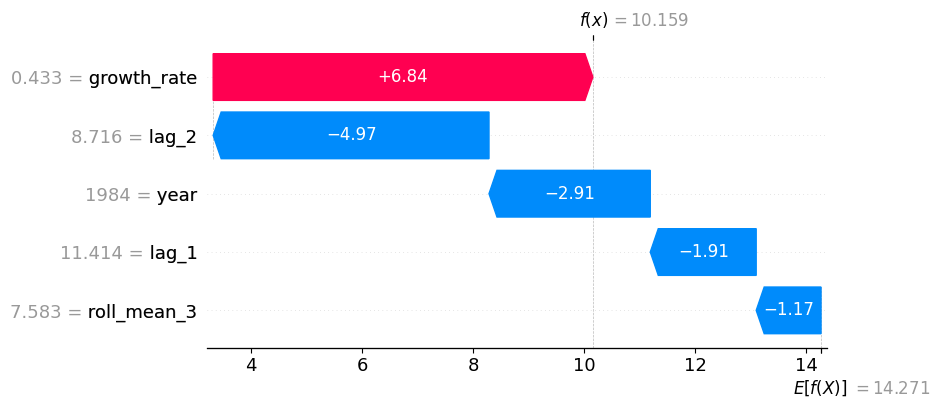

In [20]:
import shap
import matplotlib.pyplot as plt

# SHAP EXPLAINER
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# 1. Beeswarm Plot
plt.title("SHAP Summary — Bulk carriers")
shap.plots.beeswarm(shap_values, max_display=10)

# 2. Bar Plot
shap.plots.bar(shap_values, max_display=10)

# 3. Waterfall plot
shap.plots.waterfall(shap_values[0])


=== XGBOOST RESULTS (General cargo) ===
RMSE_train: 7.02
RMSE_test : 2.91
PE_train  : 5.00%
PE_test   : 3.40%
R²_train  : -0.002
R²_test   : -4.625


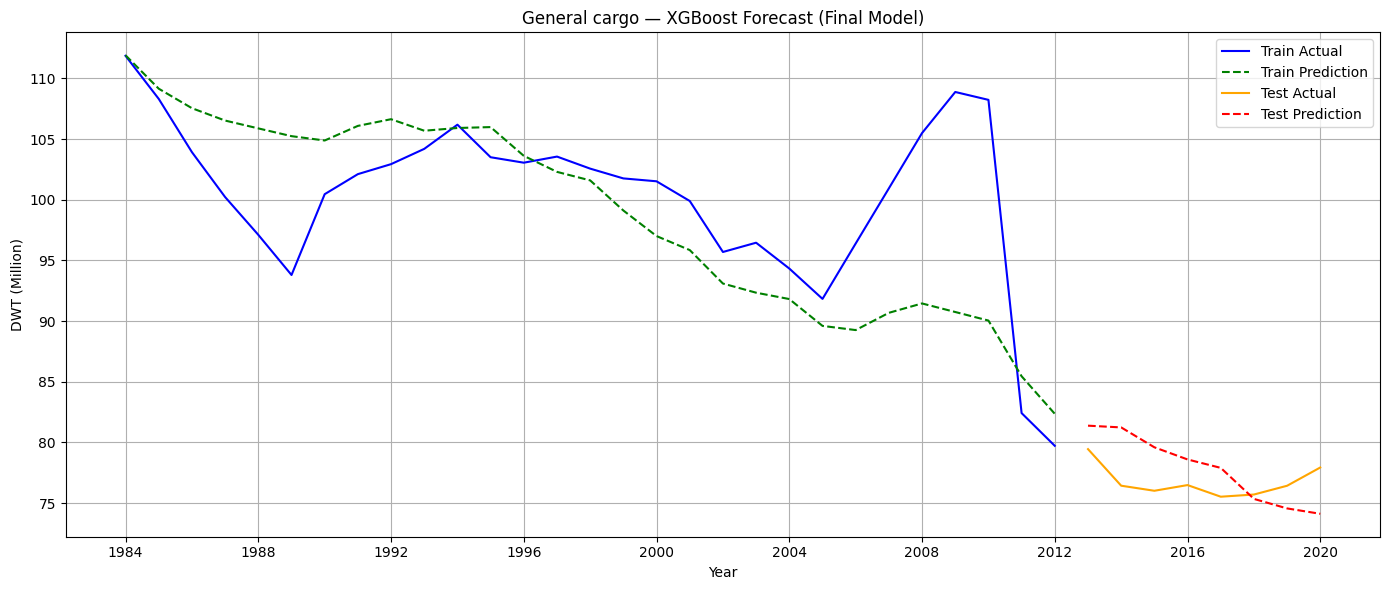

In [21]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === STEP 1
ship = "General cargo"
dship = df[df["ShipType Label"] == ship].sort_values("Year")

# === STEP 2:
y = pd.Series(dship["DWT_million"].values, index=pd.to_datetime(dship["Year"], format="%Y")).asfreq("YS")
y = y.interpolate(method="time")
y_diff = y.diff().dropna()

# === STEP 3:
def create_features(y, y_original=None):
    df_feat = pd.DataFrame({"y": y})


    df_feat["lag_1"] = df_feat["y"].shift(1)
    df_feat["lag_2"] = df_feat["y"].shift(2)
    df_feat["lag_3"] = df_feat["y"].shift(3)



    if y_original is not None:
        growth = y_original.pct_change().shift(1)
        df_feat["growth_rate"] = (growth - growth.mean()) / growth.std()

    df_feat.dropna(inplace=True)
    return df_feat


df_feat = create_features(y_diff, y_original=y)
X = df_feat.drop(columns=["y"])
y_target = df_feat["y"]

# === STEP 4:
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y_target.iloc[:split_index], y_target.iloc[split_index:]

# === STEP 5:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    learning_rate=0.02,
    max_depth=3,
    min_child_weight=5,
    n_estimators=300,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=5,
    reg_lambda=10,
    random_state=42
)

model.fit(X_train, y_train)

# === STEP 6:
train_start = y.loc[X_train.index[0] - pd.DateOffset(years=1)]
y_pred_train = pd.Series(train_start + np.cumsum(model.predict(X_train)), index=X_train.index)
last_train_val = y_pred_train.iloc[-1]
y_pred_test = pd.Series(last_train_val + np.cumsum(model.predict(X_test)), index=X_test.index)

# === STEP 7:
y_train_actual = y.loc[X_train.index]
y_test_actual = y.loc[X_test.index]

# === STEP 8:
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))
pe_train = np.mean(np.abs((y_train_actual - y_pred_train) / y_train_actual)) * 100
pe_test = np.mean(np.abs((y_test_actual - y_pred_test) / y_test_actual)) * 100
r2_train = r2_score(y_train_actual, y_pred_train)
r2_test = r2_score(y_test_actual, y_pred_test)

# === STEP 9:
print("\n=== XGBOOST RESULTS (General cargo) ===")
print(f"RMSE_train: {rmse_train:.2f}")
print(f"RMSE_test : {rmse_test:.2f}")
print(f"PE_train  : {pe_train:.2f}%")
print(f"PE_test   : {pe_test:.2f}%")
print(f"R²_train  : {r2_train:.3f}")
print(f"R²_test   : {r2_test:.3f}")

# === STEP 10:
plt.figure(figsize=(14,6))
plt.plot(y_train_actual, label="Train Actual", color="blue")
plt.plot(y_pred_train, label="Train Prediction", linestyle="--", color="green")
plt.plot(y_test_actual, label="Test Actual", color="orange")
plt.plot(y_pred_test, label="Test Prediction", linestyle="--", color="red")
plt.title(f"{ship} — XGBoost Forecast (Final Model)")
plt.xlabel("Year")
plt.ylabel("DWT (Million)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== XGBOOST RESULTS (Other types of ships) ===
RMSE_train: 17.64
RMSE_test : 9.44
PE_train  : 22.08%
PE_test   : 3.49%
R²_train  : 0.694
R²_test   : 0.749


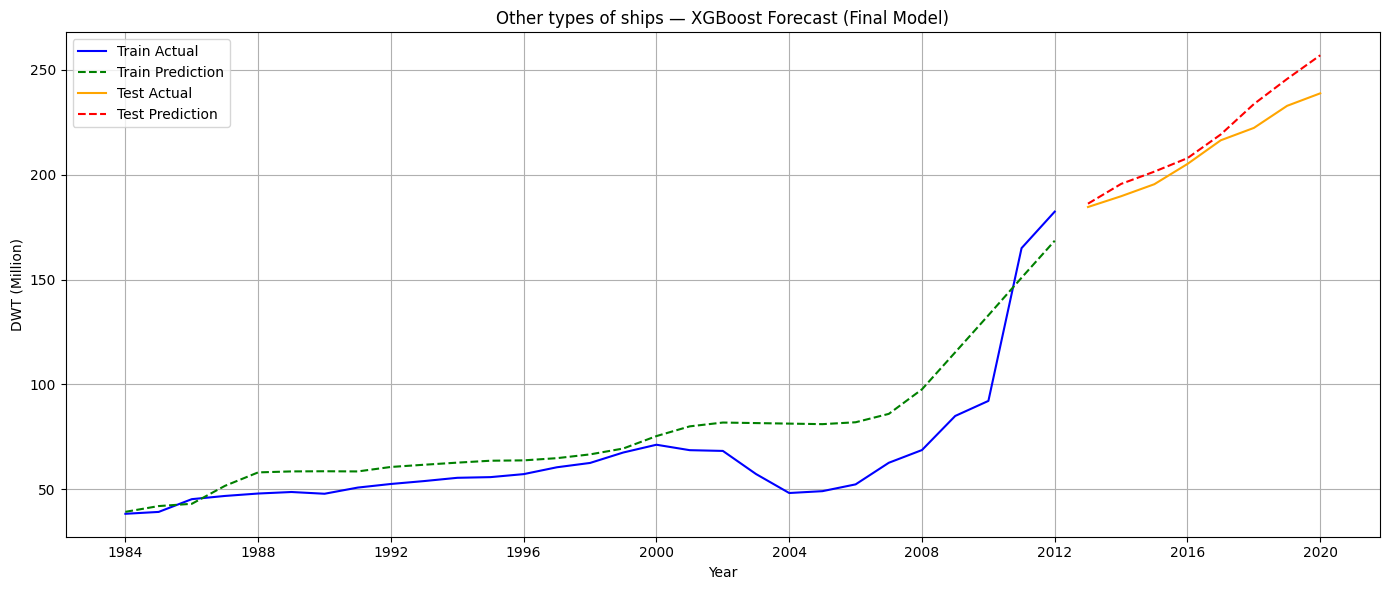

In [22]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === STEP 1:
ship = "Other types of ships"
dship = df[df["ShipType Label"] == ship].sort_values("Year")

# === STEP 2:
y = pd.Series(dship["DWT_million"].values, index=pd.to_datetime(dship["Year"], format="%Y")).asfreq("YS")
y = y.interpolate(method="time")
y_diff = y.diff().dropna()

# === STEP 3
def create_features(y, y_original=None):
    df_feat = pd.DataFrame({"y": y})
    df_feat["lag_1"] = df_feat["y"].shift(1)
    df_feat["lag_2"] = df_feat["y"].shift(2)
    df_feat["roll_mean_3"] = df_feat["y"].shift(1).rolling(3).mean()

    if y_original is not None:
        growth = y_original.pct_change().shift(1)
        df_feat["growth_rate"] = (growth - growth.mean()) / growth.std()

    df_feat.dropna(inplace=True)
    return df_feat

df_feat = create_features(y_diff, y_original=y)
X = df_feat.drop(columns=["y"])
y_target = df_feat["y"]

# === STEP 4:
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y_target.iloc[:split_index], y_target.iloc[split_index:]

# === STEP 5:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    learning_rate=0.05,
    max_depth=2,
    min_child_weight=5,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=5,
    reg_lambda=10,
    random_state=42
)

model.fit(X_train, y_train)

# === STEP 6:
train_start = y.loc[X_train.index[0] - pd.DateOffset(years=1)]
y_pred_train = pd.Series(train_start + np.cumsum(model.predict(X_train)), index=X_train.index)
last_train_val = y_pred_train.iloc[-1]
y_pred_test = pd.Series(last_train_val + np.cumsum(model.predict(X_test)), index=X_test.index)

# === STEP 7:
y_train_actual = y.loc[X_train.index]
y_test_actual = y.loc[X_test.index]

# === STEP 8:
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))
pe_train = np.mean(np.abs((y_train_actual - y_pred_train) / y_train_actual)) * 100
pe_test = np.mean(np.abs((y_test_actual - y_pred_test) / y_test_actual)) * 100
r2_train = r2_score(y_train_actual, y_pred_train)
r2_test = r2_score(y_test_actual, y_pred_test)

# === STEP 9:
print(f"\n=== XGBOOST RESULTS ({ship}) ===")
print(f"RMSE_train: {rmse_train:.2f}")
print(f"RMSE_test : {rmse_test:.2f}")
print(f"PE_train  : {pe_train:.2f}%")
print(f"PE_test   : {pe_test:.2f}%")
print(f"R²_train  : {r2_train:.3f}")
print(f"R²_test   : {r2_test:.3f}")

# === STEP 10:
plt.figure(figsize=(14,6))
plt.plot(y_train_actual, label="Train Actual", color="blue")
plt.plot(y_pred_train, label="Train Prediction", linestyle="--", color="green")
plt.plot(y_test_actual, label="Test Actual", color="orange")
plt.plot(y_pred_test, label="Test Prediction", linestyle="--", color="red")
plt.title(f"{ship} — XGBoost Forecast (Final Model)")
plt.xlabel("Year")
plt.ylabel("DWT (Million)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔍 Processing SHAP for: Total fleet

✅ SHAP summary for: Total fleet


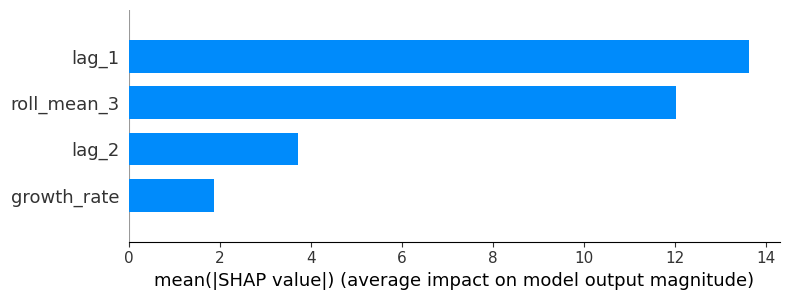

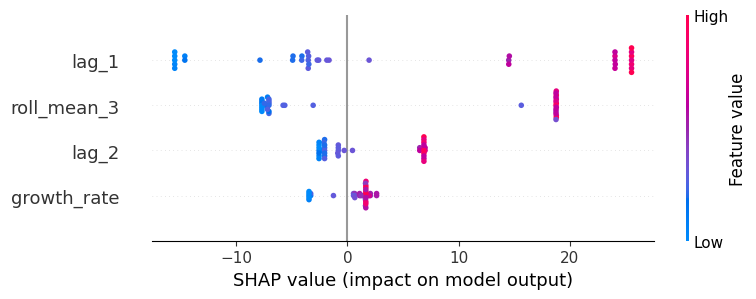


🔍 Processing SHAP for: Oil tankers

✅ SHAP summary for: Oil tankers


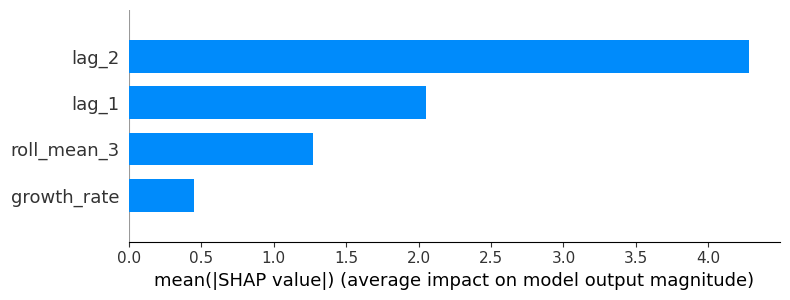

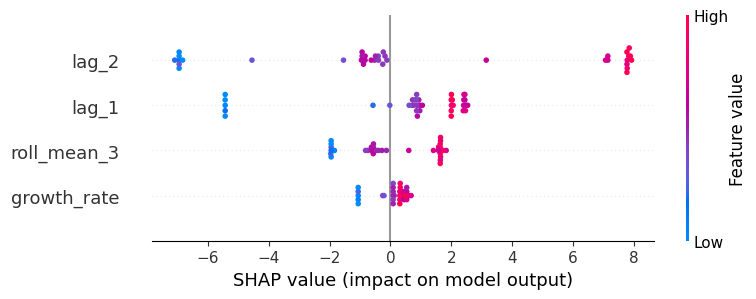


🔍 Processing SHAP for: Bulk carriers

✅ SHAP summary for: Bulk carriers


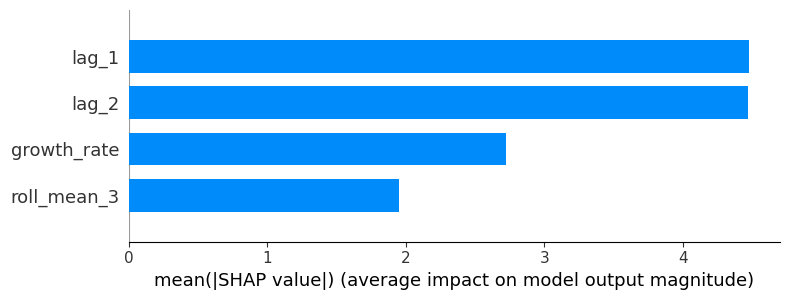

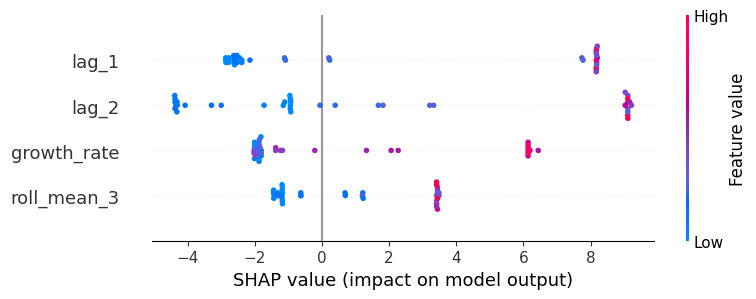


🔍 Processing SHAP for: General cargo

✅ SHAP summary for: General cargo


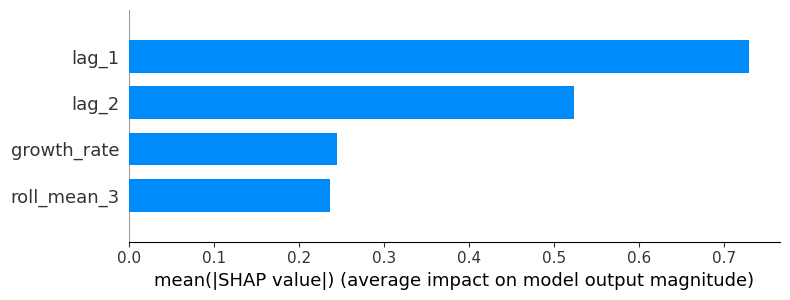

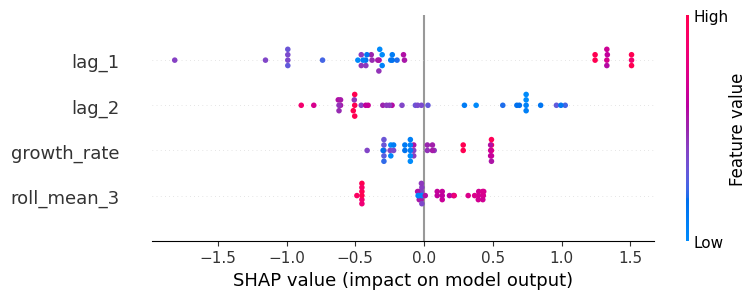


🔍 Processing SHAP for: Container ships

✅ SHAP summary for: Container ships


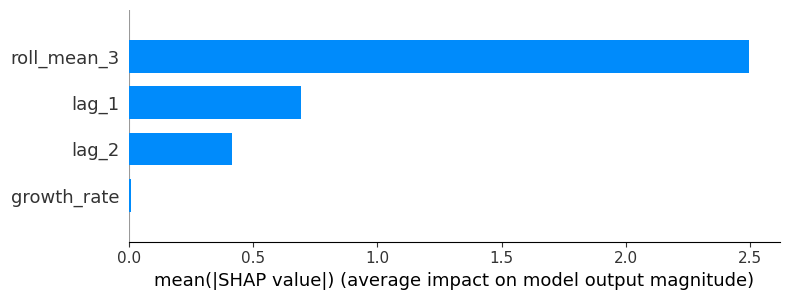

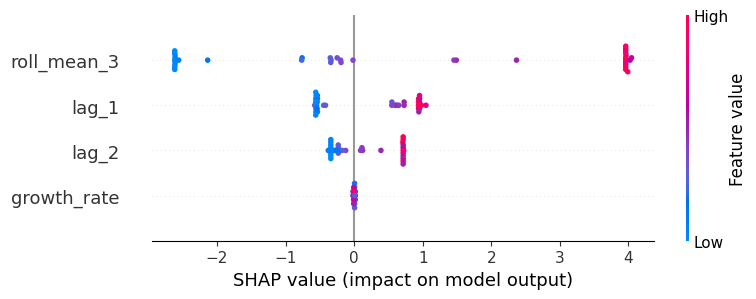


🔍 Processing SHAP for: Other types of ships

✅ SHAP summary for: Other types of ships


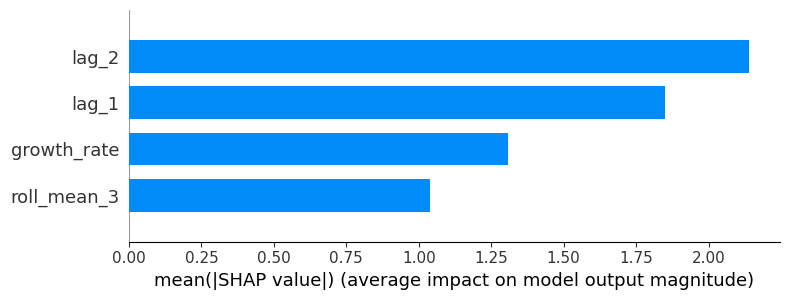

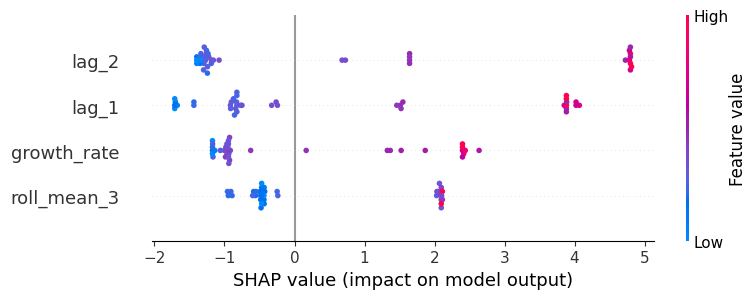

In [23]:
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

def prepare_data(df, ship_type):
    dship = df[df["ShipType Label"] == ship_type].sort_values("Year")
    y = pd.Series(dship["DWT_million"].values, index=pd.to_datetime(dship["Year"], format="%Y")).asfreq("YS")
    y = y.interpolate(method="time")
    y_diff = y.diff().dropna()
    return y, y_diff

def create_features(y, y_original=None):
    df_feat = pd.DataFrame({"y": y})
    df_feat["lag_1"] = df_feat["y"].shift(1)
    df_feat["lag_2"] = df_feat["y"].shift(2)
    df_feat["roll_mean_3"] = df_feat["y"].shift(1).rolling(3).mean()
    if y_original is not None:
        growth = y_original.pct_change().shift(1)
        df_feat["growth_rate"] = (growth - growth.mean()) / growth.std()
    df_feat.dropna(inplace=True)
    return df_feat

def train_model(X_train, y_train):
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        learning_rate=0.05,
        max_depth=2,
        min_child_weight=5,
        n_estimators=100,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=5,
        reg_lambda=10,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

def shap_analysis(model, X, ship_type):
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    print(f"\n✅ SHAP summary for: {ship_type}")
    shap.summary_plot(shap_values, X, plot_type="bar", show=True)  # Feature importance
    shap.summary_plot(shap_values, X, show=True)                   # Detailed plot

# ===============================
# 🧪 Example run: loop over ships
# ===============================

ship_types = df["ShipType Label"].unique()

for ship in ship_types:
    print(f"\n🔍 Processing SHAP for: {ship}")
    y, y_diff = prepare_data(df, ship)
    df_feat = create_features(y_diff, y_original=y)
    X = df_feat.drop(columns=["y"])
    y_target = df_feat["y"]

    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_target.iloc[:split_idx], y_target.iloc[split_idx:]

    model = train_model(X_train, y_train)
    shap_analysis(model, X, ship)

In [24]:
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

print("\nYears check:")
print("Train:", X_train.index.year.min(), "→", X_train.index.year.max())
print("Test :", X_test.index.year.min(),  "→", X_test.index.year.max())

X_train shape: (29, 4)
X_test  shape: (8, 4)

Years check:
Train: 1984 → 2012
Test : 2013 → 2020



=== FINAL XGBOOST RESULTS (y.diff + features) ===
Train → RMSE: 19.67 | PE: 1.39%
Test  → RMSE: 151.33 | PE: 6.97%


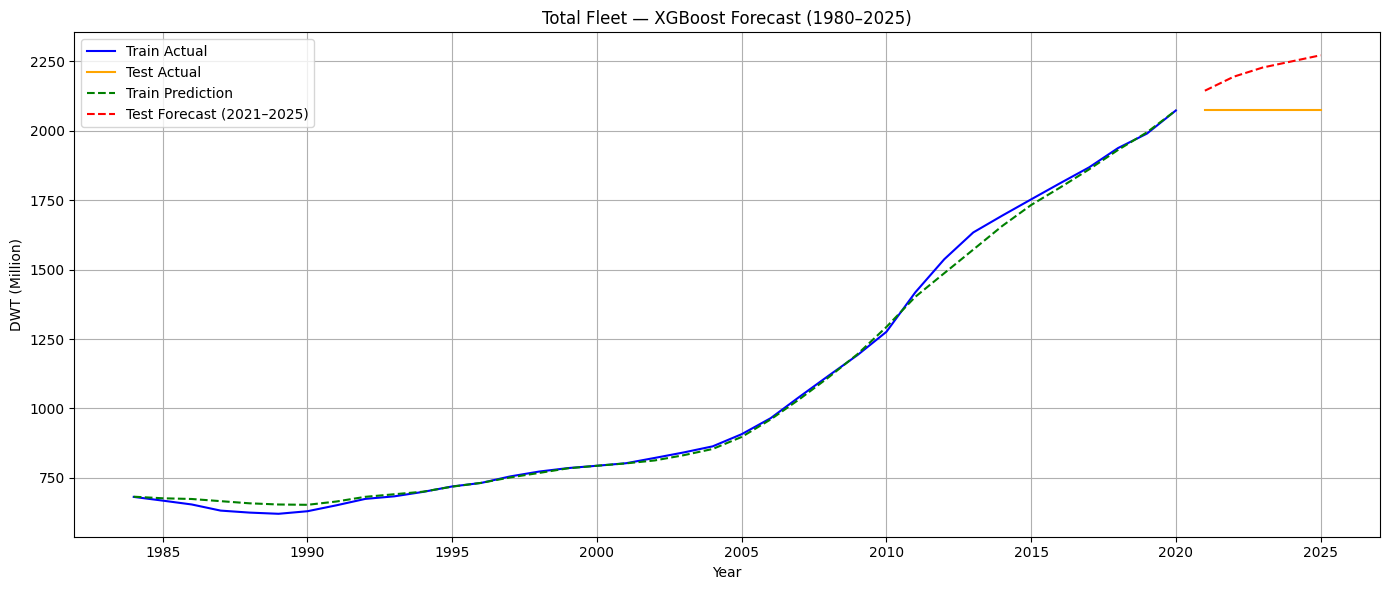

In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# =========================================================
# STEP 0: Prepare full time series (1980–2025)
# =========================================================
ship = "Total fleet"
dship = df[df["ShipType Label"] == ship].sort_values("Year")

y_full = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(dship["Year"], format="%Y")
).asfreq("YS")

full_index = pd.date_range("1980-01-01", "2025-01-01", freq="YS")
y_full = y_full.reindex(full_index)
y_full = y_full.interpolate("time")

y_diff = y_full.diff()

# =========================================================
# STEP 1: Feature engineering
# =========================================================
def create_features(y, y_original):
    df_feat = pd.DataFrame({"y": y})

    df_feat["lag_1"] = df_feat["y"].shift(1)
    df_feat["lag_2"] = df_feat["y"].shift(2)

    df_feat["roll_mean_3"] = df_feat["y"].shift(1).rolling(3).mean()
    df_feat["roll_std_3"]  = df_feat["y"].shift(1).rolling(3).std()

    crisis_years = [2008, 2009, 2010, 2020]
    df_feat["crisis_flag"] = df_feat.index.year.isin(crisis_years).astype(int)

    growth = y_original.pct_change().shift(1)
    df_feat["growth_rate"] = (growth - growth.mean()) / growth.std()

    df_feat["year_norm"] = (
        (df_feat.index.year - df_feat.index.year.min()) /
        (df_feat.index.year.max() - df_feat.index.year.min())
    )

    return df_feat.dropna()

df_feat = create_features(y_diff, y_full)
X = df_feat.drop(columns="y")
y_target = df_feat["y"]

# =========================================================
# STEP 2: Train/Test split (train until 2020)
# =========================================================
train_end_year = 2020
X_train = X[X.index.year <= train_end_year]
X_test  = X[X.index.year >  train_end_year]

y_train = y_target.loc[X_train.index]
y_test  = y_target.loc[X_test.index]

# =========================================================
# STEP 3: Model
# =========================================================
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=700,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=3,
    reg_lambda=10,
    random_state=42
)

model.fit(X_train, y_train)

# =========================================================
# STEP 4: Predict & reconstruct y
# =========================================================
y_pred_train_diff = model.predict(X_train)
y_pred_test_diff  = model.predict(X_test)

train_start = y_full.loc[X_train.index[0] - pd.DateOffset(years=1)]
last_train  = y_full.loc[X_train.index[-1]]

y_pred_train = pd.Series(train_start + np.cumsum(y_pred_train_diff), index=X_train.index)
y_pred_test  = pd.Series(last_train  + np.cumsum(y_pred_test_diff),  index=X_test.index)

y_train_actual = y_full.loc[X_train.index]
y_test_actual  = y_full.loc[X_test.index]

# =========================================================
# STEP 5: Evaluation
# =========================================================
# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))

# PE (% Error)
pe_train = np.mean(np.abs((y_train_actual - y_pred_train) / y_train_actual)) * 100
pe_test  = np.mean(np.abs((y_test_actual  - y_pred_test)  / y_test_actual)) * 100


print("\n=== FINAL XGBOOST RESULTS (y.diff + features) ===")
print(f"Train → RMSE: {rmse_train:.2f} | PE: {pe_train:.2f}%")
print(f"Test  → RMSE: {rmse_test:.2f} | PE: {pe_test:.2f}%")


# =========================================================
# STEP 6: Plot until 2025
# =========================================================
plt.figure(figsize=(14,6))

plt.plot(y_train_actual, label="Train Actual", color="blue")
plt.plot(y_test_actual,  label="Test Actual",  color="orange")

plt.plot(y_pred_train, "--", label="Train Prediction", color="green")
plt.plot(y_pred_test,  "--", label="Test Forecast (2021–2025)", color="red")

plt.title("Total Fleet — XGBoost Forecast (1980–2025)")
plt.xlabel("Year")
plt.ylabel("DWT (Million)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== FINAL XGBOOST RESULTS (y.diff + features) ===
Train → RMSE: 8.14 | PE: 1.84%
Test  → RMSE: 30.05 | PE: 4.78%


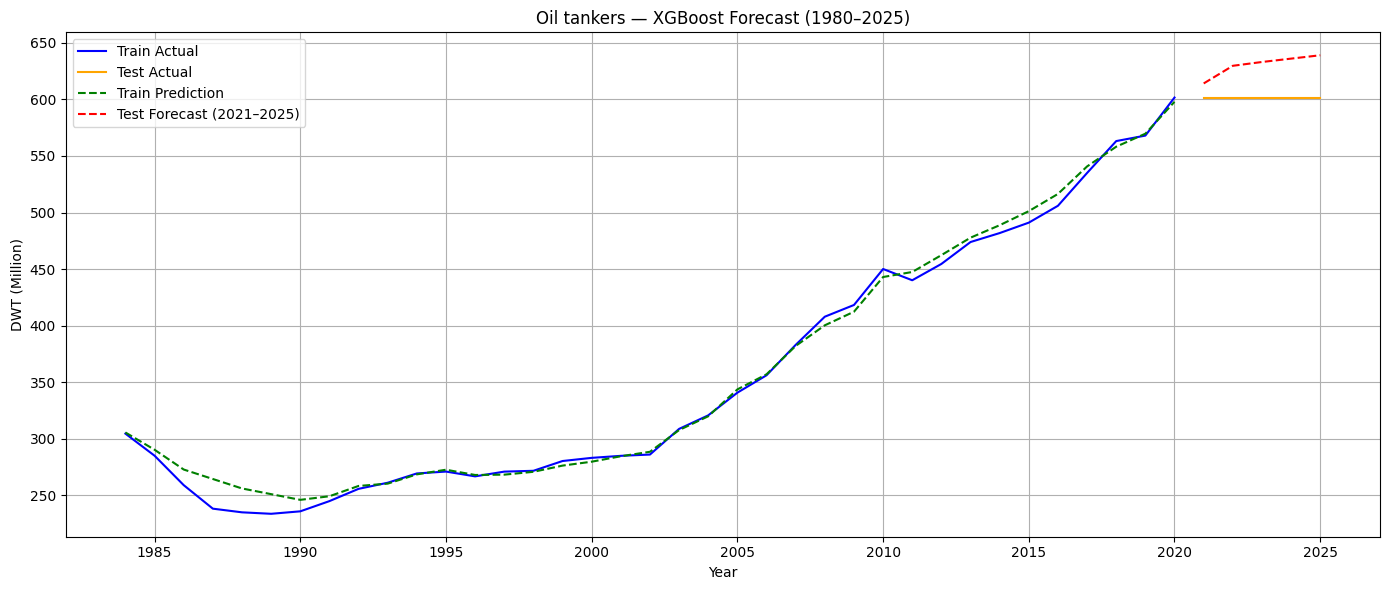

In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# =========================================================
# STEP 0: Prepare full time series (1980–2025)
# =========================================================
ship = "Oil tankers"
dship = df[df["ShipType Label"] == ship].sort_values("Year")

y_full = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(dship["Year"], format="%Y")
).asfreq("YS")

full_index = pd.date_range("1980-01-01", "2025-01-01", freq="YS")
y_full = y_full.reindex(full_index)
y_full = y_full.interpolate("time")

y_diff = y_full.diff()

# =========================================================
# STEP 1: Feature engineering
# =========================================================
def create_features(y, y_original):
    df_feat = pd.DataFrame({"y": y})

    df_feat["lag_1"] = df_feat["y"].shift(1)
    df_feat["lag_2"] = df_feat["y"].shift(2)

    df_feat["roll_mean_3"] = df_feat["y"].shift(1).rolling(3).mean()
    df_feat["roll_std_3"]  = df_feat["y"].shift(1).rolling(3).std()

    crisis_years = [2008, 2009, 2010, 2020]
    df_feat["crisis_flag"] = df_feat.index.year.isin(crisis_years).astype(int)

    growth = y_original.pct_change().shift(1)
    df_feat["growth_rate"] = (growth - growth.mean()) / growth.std()

    df_feat["year_norm"] = (
        (df_feat.index.year - df_feat.index.year.min()) /
        (df_feat.index.year.max() - df_feat.index.year.min())
    )

    return df_feat.dropna()

df_feat = create_features(y_diff, y_full)
X = df_feat.drop(columns="y")
y_target = df_feat["y"]

# =========================================================
# STEP 2: Train/Test split (train until 2020)
# =========================================================
train_end_year = 2020
X_train = X[X.index.year <= train_end_year]
X_test  = X[X.index.year >  train_end_year]

y_train = y_target.loc[X_train.index]
y_test  = y_target.loc[X_test.index]

# =========================================================
# STEP 3: Model
# =========================================================
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=700,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=3,
    reg_lambda=10,
    random_state=42
)

model.fit(X_train, y_train)

# =========================================================
# STEP 4: Predict & reconstruct y
# =========================================================
y_pred_train_diff = model.predict(X_train)
y_pred_test_diff  = model.predict(X_test)

train_start = y_full.loc[X_train.index[0] - pd.DateOffset(years=1)]
last_train  = y_full.loc[X_train.index[-1]]

y_pred_train = pd.Series(train_start + np.cumsum(y_pred_train_diff), index=X_train.index)
y_pred_test  = pd.Series(last_train  + np.cumsum(y_pred_test_diff),  index=X_test.index)

y_train_actual = y_full.loc[X_train.index]
y_test_actual  = y_full.loc[X_test.index]

# =========================================================
# STEP 5: Evaluation
# =========================================================
# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))

# PE (% Error)
pe_train = np.mean(np.abs((y_train_actual - y_pred_train) / y_train_actual)) * 100
pe_test  = np.mean(np.abs((y_test_actual  - y_pred_test)  / y_test_actual)) * 100


print("\n=== FINAL XGBOOST RESULTS (y.diff + features) ===")
print(f"Train → RMSE: {rmse_train:.2f} | PE: {pe_train:.2f}%")
print(f"Test  → RMSE: {rmse_test:.2f} | PE: {pe_test:.2f}%")


# =========================================================
# STEP 6: Plot until 2025
# =========================================================
plt.figure(figsize=(14,6))

plt.plot(y_train_actual, label="Train Actual", color="blue")
plt.plot(y_test_actual,  label="Test Actual",  color="orange")

plt.plot(y_pred_train, "--", label="Train Prediction", color="green")
plt.plot(y_pred_test,  "--", label="Test Forecast (2021–2025)", color="red")

plt.title("Oil tankers — XGBoost Forecast (1980–2025)")
plt.xlabel("Year")
plt.ylabel("DWT (Million)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== FINAL XGBOOST RESULTS (y.diff + features) ===
Train → RMSE: 11.91 | PE: 1.25%
Test  → RMSE: 94.72 | PE: 9.75%


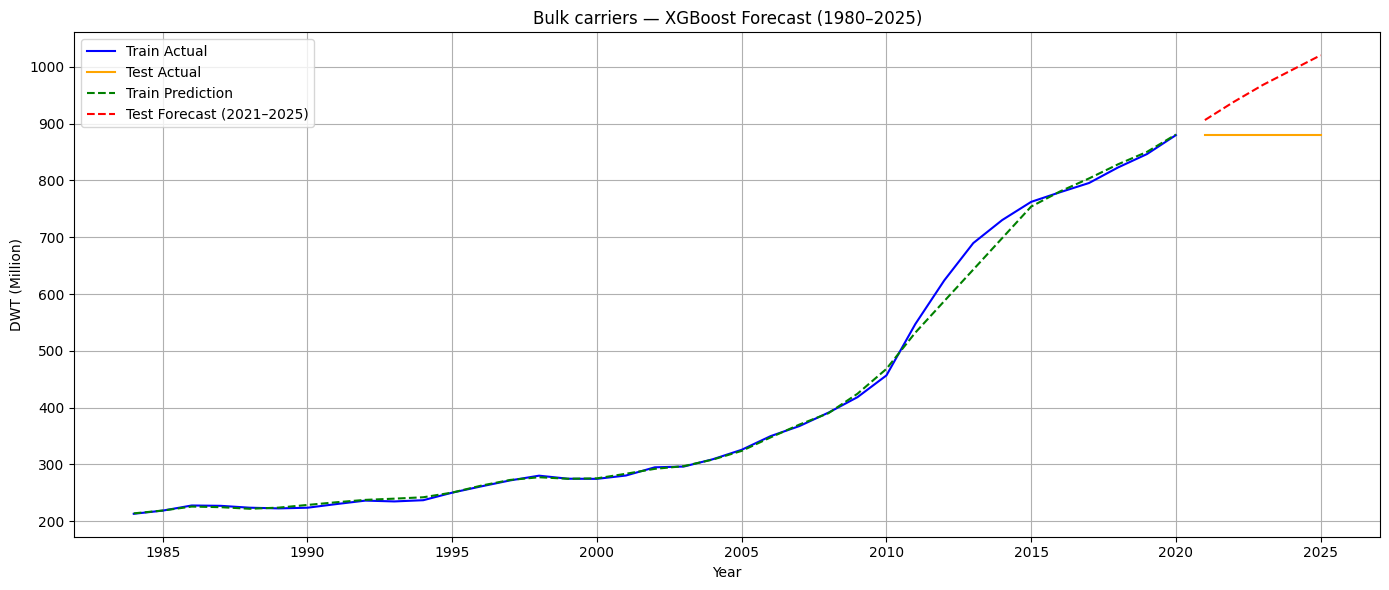

In [27]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# =========================================================
# STEP 0: Prepare full time series (1980–2025)
# =========================================================
ship = "Bulk carriers"
dship = df[df["ShipType Label"] == ship].sort_values("Year")

y_full = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(dship["Year"], format="%Y")
).asfreq("YS")

full_index = pd.date_range("1980-01-01", "2025-01-01", freq="YS")
y_full = y_full.reindex(full_index)
y_full = y_full.interpolate("time")

y_diff = y_full.diff()

# =========================================================
# STEP 1: Feature engineering
# =========================================================
def create_features(y, y_original):
    df_feat = pd.DataFrame({"y": y})

    df_feat["lag_1"] = df_feat["y"].shift(1)
    df_feat["lag_2"] = df_feat["y"].shift(2)

    df_feat["roll_mean_3"] = df_feat["y"].shift(1).rolling(3).mean()
    df_feat["roll_std_3"]  = df_feat["y"].shift(1).rolling(3).std()

    crisis_years = [2008, 2009, 2010, 2020]
    df_feat["crisis_flag"] = df_feat.index.year.isin(crisis_years).astype(int)

    growth = y_original.pct_change().shift(1)
    df_feat["growth_rate"] = (growth - growth.mean()) / growth.std()

    df_feat["year_norm"] = (
        (df_feat.index.year - df_feat.index.year.min()) /
        (df_feat.index.year.max() - df_feat.index.year.min())
    )

    return df_feat.dropna()

df_feat = create_features(y_diff, y_full)
X = df_feat.drop(columns="y")
y_target = df_feat["y"]

# =========================================================
# STEP 2: Train/Test split (train until 2020)
# =========================================================
train_end_year = 2020
X_train = X[X.index.year <= train_end_year]
X_test  = X[X.index.year >  train_end_year]

y_train = y_target.loc[X_train.index]
y_test  = y_target.loc[X_test.index]

# =========================================================
# STEP 3: Model
# =========================================================
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=700,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=3,
    reg_lambda=10,
    random_state=42
)

model.fit(X_train, y_train)

# =========================================================
# STEP 4: Predict & reconstruct y
# =========================================================
y_pred_train_diff = model.predict(X_train)
y_pred_test_diff  = model.predict(X_test)

train_start = y_full.loc[X_train.index[0] - pd.DateOffset(years=1)]
last_train  = y_full.loc[X_train.index[-1]]

y_pred_train = pd.Series(train_start + np.cumsum(y_pred_train_diff), index=X_train.index)
y_pred_test  = pd.Series(last_train  + np.cumsum(y_pred_test_diff),  index=X_test.index)

y_train_actual = y_full.loc[X_train.index]
y_test_actual  = y_full.loc[X_test.index]

# =========================================================
# STEP 5: Evaluation
# =========================================================
# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))

# PE (% Error)
pe_train = np.mean(np.abs((y_train_actual - y_pred_train) / y_train_actual)) * 100
pe_test  = np.mean(np.abs((y_test_actual  - y_pred_test)  / y_test_actual)) * 100


print("\n=== FINAL XGBOOST RESULTS (y.diff + features) ===")
print(f"Train → RMSE: {rmse_train:.2f} | PE: {pe_train:.2f}%")
print(f"Test  → RMSE: {rmse_test:.2f} | PE: {pe_test:.2f}%")


# =========================================================
# STEP 6: Plot until 2025
# =========================================================
plt.figure(figsize=(14,6))

plt.plot(y_train_actual, label="Train Actual", color="blue")
plt.plot(y_test_actual,  label="Test Actual",  color="orange")

plt.plot(y_pred_train, "--", label="Train Prediction", color="green")
plt.plot(y_pred_test,  "--", label="Test Forecast (2021–2025)", color="red")

plt.title("Bulk carriers — XGBoost Forecast (1980–2025)")
plt.xlabel("Year")
plt.ylabel("DWT (Million)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== FINAL XGBOOST RESULTS (y.diff + features) ===
Train → RMSE: 2.97 | PE: 2.37%
Test  → RMSE: 7.03 | PE: 7.75%


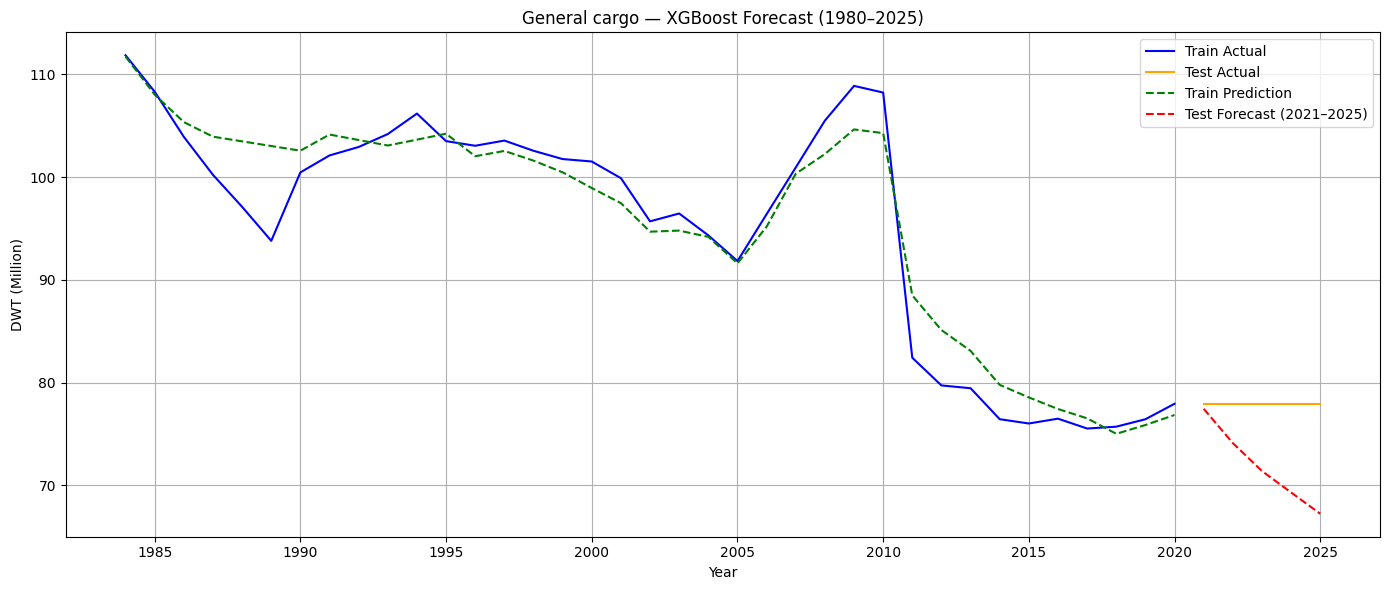

In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# =========================================================
# STEP 0: Prepare full time series (1980–2025)
# =========================================================
ship = "General cargo"
dship = df[df["ShipType Label"] == ship].sort_values("Year")

y_full = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(dship["Year"], format="%Y")
).asfreq("YS")

full_index = pd.date_range("1980-01-01", "2025-01-01", freq="YS")
y_full = y_full.reindex(full_index)
y_full = y_full.interpolate("time")

y_diff = y_full.diff()

# =========================================================
# STEP 1: Feature engineering
# =========================================================
def create_features(y, y_original):
    df_feat = pd.DataFrame({"y": y})

    df_feat["lag_1"] = df_feat["y"].shift(1)
    df_feat["lag_2"] = df_feat["y"].shift(2)

    df_feat["roll_mean_3"] = df_feat["y"].shift(1).rolling(3).mean()
    df_feat["roll_std_3"]  = df_feat["y"].shift(1).rolling(3).std()

    crisis_years = [2008, 2009, 2010, 2020]
    df_feat["crisis_flag"] = df_feat.index.year.isin(crisis_years).astype(int)

    growth = y_original.pct_change().shift(1)
    df_feat["growth_rate"] = (growth - growth.mean()) / growth.std()

    df_feat["year_norm"] = (
        (df_feat.index.year - df_feat.index.year.min()) /
        (df_feat.index.year.max() - df_feat.index.year.min())
    )

    return df_feat.dropna()

df_feat = create_features(y_diff, y_full)
X = df_feat.drop(columns="y")
y_target = df_feat["y"]

# =========================================================
# STEP 2: Train/Test split (train until 2020)
# =========================================================
train_end_year = 2020
X_train = X[X.index.year <= train_end_year]
X_test  = X[X.index.year >  train_end_year]

y_train = y_target.loc[X_train.index]
y_test  = y_target.loc[X_test.index]

# =========================================================
# STEP 3: Model
# =========================================================
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=700,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=3,
    reg_lambda=10,
    random_state=42
)

model.fit(X_train, y_train)

# =========================================================
# STEP 4: Predict & reconstruct y
# =========================================================
y_pred_train_diff = model.predict(X_train)
y_pred_test_diff  = model.predict(X_test)

train_start = y_full.loc[X_train.index[0] - pd.DateOffset(years=1)]
last_train  = y_full.loc[X_train.index[-1]]

y_pred_train = pd.Series(train_start + np.cumsum(y_pred_train_diff), index=X_train.index)
y_pred_test  = pd.Series(last_train  + np.cumsum(y_pred_test_diff),  index=X_test.index)

y_train_actual = y_full.loc[X_train.index]
y_test_actual  = y_full.loc[X_test.index]

# =========================================================
# STEP 5: Evaluation
# =========================================================
# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))

# PE (% Error)
pe_train = np.mean(np.abs((y_train_actual - y_pred_train) / y_train_actual)) * 100
pe_test  = np.mean(np.abs((y_test_actual  - y_pred_test)  / y_test_actual)) * 100


print("\n=== FINAL XGBOOST RESULTS (y.diff + features) ===")
print(f"Train → RMSE: {rmse_train:.2f} | PE: {pe_train:.2f}%")
print(f"Test  → RMSE: {rmse_test:.2f} | PE: {pe_test:.2f}%")


# =========================================================
# STEP 6: Plot until 2025
# =========================================================
plt.figure(figsize=(14,6))

plt.plot(y_train_actual, label="Train Actual", color="blue")
plt.plot(y_test_actual,  label="Test Actual",  color="orange")

plt.plot(y_pred_train, "--", label="Train Prediction", color="green")
plt.plot(y_pred_test,  "--", label="Test Forecast (2021–2025)", color="red")

plt.title("General cargo — XGBoost Forecast (1980–2025)")
plt.xlabel("Year")
plt.ylabel("DWT (Million)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== FINAL XGBOOST RESULTS (y.diff + features) ===
Train → RMSE: 2.46 | PE: 2.52%
Test  → RMSE: 24.79 | PE: 8.55%


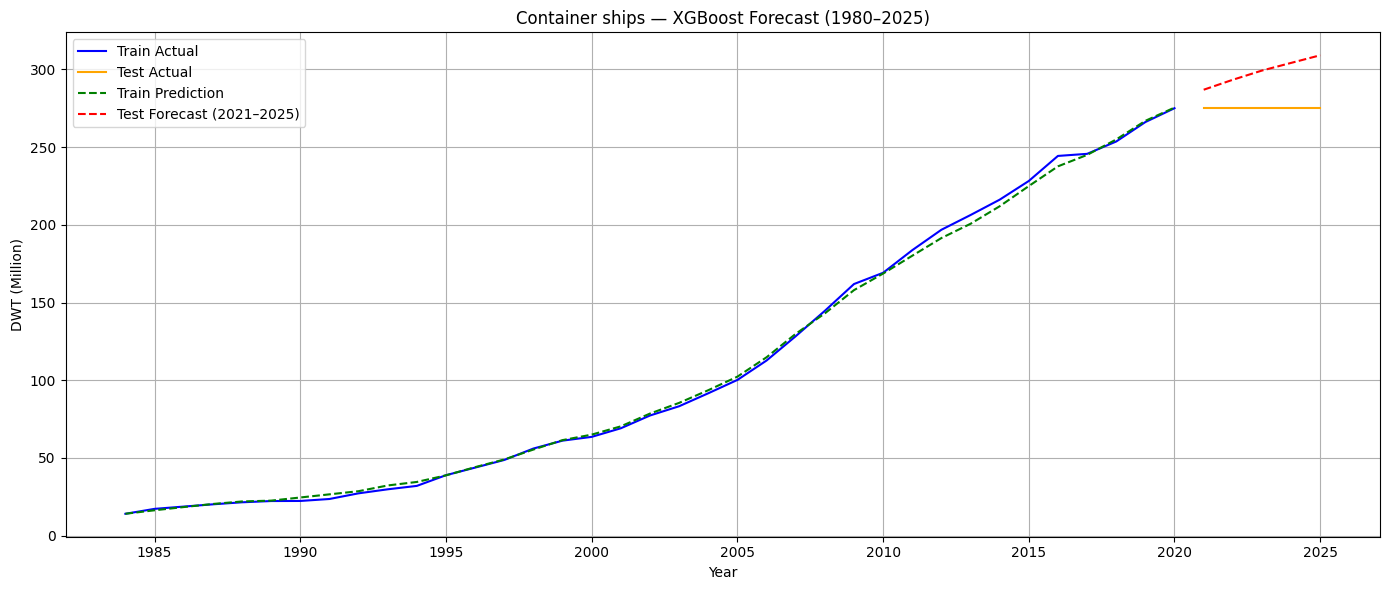

In [29]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# =========================================================
# STEP 0: Prepare full time series (1980–2025)
# =========================================================
ship = "Container ships"
dship = df[df["ShipType Label"] == ship].sort_values("Year")

y_full = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(dship["Year"], format="%Y")
).asfreq("YS")

full_index = pd.date_range("1980-01-01", "2025-01-01", freq="YS")
y_full = y_full.reindex(full_index)
y_full = y_full.interpolate("time")

y_diff = y_full.diff()

# =========================================================
# STEP 1: Feature engineering
# =========================================================
def create_features(y, y_original):
    df_feat = pd.DataFrame({"y": y})

    df_feat["lag_1"] = df_feat["y"].shift(1)
    df_feat["lag_2"] = df_feat["y"].shift(2)

    df_feat["roll_mean_3"] = df_feat["y"].shift(1).rolling(3).mean()
    df_feat["roll_std_3"]  = df_feat["y"].shift(1).rolling(3).std()

    crisis_years = [2008, 2009, 2010, 2020]
    df_feat["crisis_flag"] = df_feat.index.year.isin(crisis_years).astype(int)

    growth = y_original.pct_change().shift(1)
    df_feat["growth_rate"] = (growth - growth.mean()) / growth.std()

    df_feat["year_norm"] = (
        (df_feat.index.year - df_feat.index.year.min()) /
        (df_feat.index.year.max() - df_feat.index.year.min())
    )

    return df_feat.dropna()

df_feat = create_features(y_diff, y_full)
X = df_feat.drop(columns="y")
y_target = df_feat["y"]

# =========================================================
# STEP 2: Train/Test split (train until 2020)
# =========================================================
train_end_year = 2020
X_train = X[X.index.year <= train_end_year]
X_test  = X[X.index.year >  train_end_year]

y_train = y_target.loc[X_train.index]
y_test  = y_target.loc[X_test.index]

# =========================================================
# STEP 3: Model
# =========================================================
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=700,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=3,
    reg_lambda=10,
    random_state=42
)

model.fit(X_train, y_train)

# =========================================================
# STEP 4: Predict & reconstruct y
# =========================================================
y_pred_train_diff = model.predict(X_train)
y_pred_test_diff  = model.predict(X_test)

train_start = y_full.loc[X_train.index[0] - pd.DateOffset(years=1)]
last_train  = y_full.loc[X_train.index[-1]]

y_pred_train = pd.Series(train_start + np.cumsum(y_pred_train_diff), index=X_train.index)
y_pred_test  = pd.Series(last_train  + np.cumsum(y_pred_test_diff),  index=X_test.index)

y_train_actual = y_full.loc[X_train.index]
y_test_actual  = y_full.loc[X_test.index]

# =========================================================
# STEP 5: Evaluation
# =========================================================
# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))

# PE (% Error)
pe_train = np.mean(np.abs((y_train_actual - y_pred_train) / y_train_actual)) * 100
pe_test  = np.mean(np.abs((y_test_actual  - y_pred_test)  / y_test_actual)) * 100


print("\n=== FINAL XGBOOST RESULTS (y.diff + features) ===")
print(f"Train → RMSE: {rmse_train:.2f} | PE: {pe_train:.2f}%")
print(f"Test  → RMSE: {rmse_test:.2f} | PE: {pe_test:.2f}%")


# =========================================================
# STEP 6: Plot until 2025
# =========================================================
plt.figure(figsize=(14,6))

plt.plot(y_train_actual, label="Train Actual", color="blue")
plt.plot(y_test_actual,  label="Test Actual",  color="orange")

plt.plot(y_pred_train, "--", label="Train Prediction", color="green")
plt.plot(y_pred_test,  "--", label="Test Forecast (2021–2025)", color="red")

plt.title("Container ships — XGBoost Forecast (1980–2025)")
plt.xlabel("Year")
plt.ylabel("DWT (Million)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== FINAL XGBOOST RESULTS (y.diff + features) ===
Train → RMSE: 7.45 | PE: 2.80%
Test  → RMSE: 28.30 | PE: 11.03%


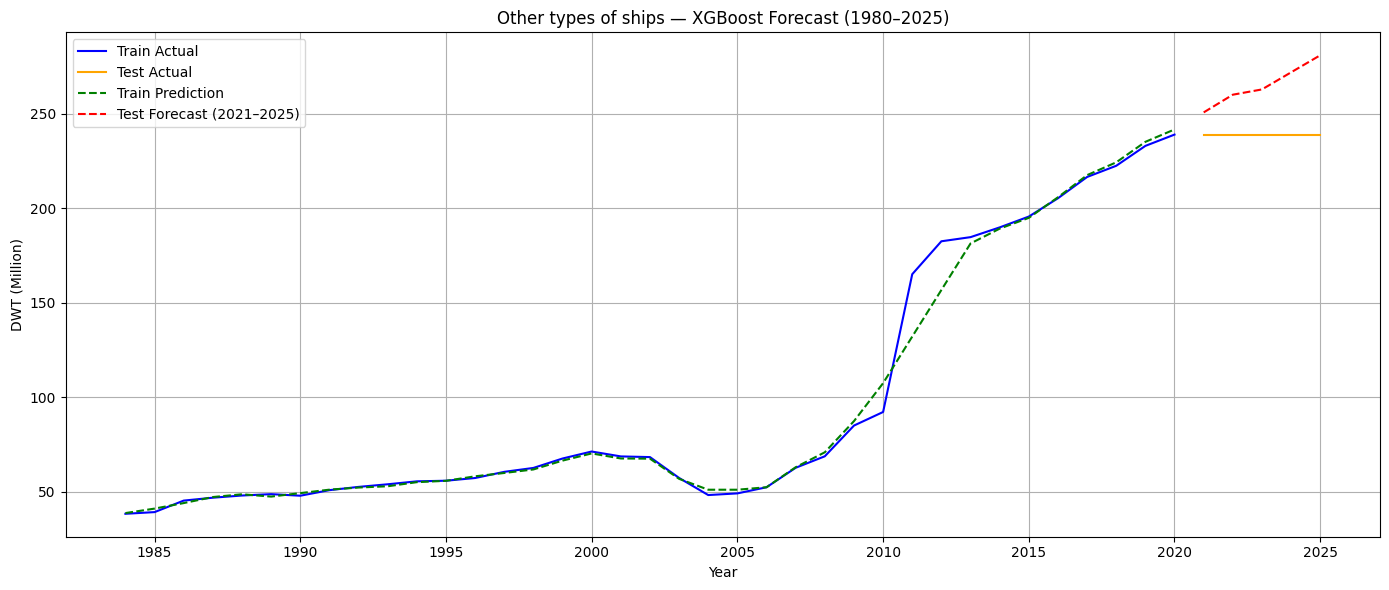

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# =========================================================
# STEP 0: Prepare full time series (1980–2025)
# =========================================================
ship = "Other types of ships"
dship = df[df["ShipType Label"] == ship].sort_values("Year")

y_full = pd.Series(
    dship["DWT_million"].values,
    index=pd.to_datetime(dship["Year"], format="%Y")
).asfreq("YS")

full_index = pd.date_range("1980-01-01", "2025-01-01", freq="YS")
y_full = y_full.reindex(full_index)
y_full = y_full.interpolate("time")

y_diff = y_full.diff()

# =========================================================
# STEP 1: Feature engineering
# =========================================================
def create_features(y, y_original):
    df_feat = pd.DataFrame({"y": y})

    df_feat["lag_1"] = df_feat["y"].shift(1)
    df_feat["lag_2"] = df_feat["y"].shift(2)

    df_feat["roll_mean_3"] = df_feat["y"].shift(1).rolling(3).mean()
    df_feat["roll_std_3"]  = df_feat["y"].shift(1).rolling(3).std()

    crisis_years = [2008, 2009, 2010, 2020]
    df_feat["crisis_flag"] = df_feat.index.year.isin(crisis_years).astype(int)

    growth = y_original.pct_change().shift(1)
    df_feat["growth_rate"] = (growth - growth.mean()) / growth.std()

    df_feat["year_norm"] = (
        (df_feat.index.year - df_feat.index.year.min()) /
        (df_feat.index.year.max() - df_feat.index.year.min())
    )

    return df_feat.dropna()

df_feat = create_features(y_diff, y_full)
X = df_feat.drop(columns="y")
y_target = df_feat["y"]

# =========================================================
# STEP 2: Train/Test split (train until 2020)
# =========================================================
train_end_year = 2020
X_train = X[X.index.year <= train_end_year]
X_test  = X[X.index.year >  train_end_year]

y_train = y_target.loc[X_train.index]
y_test  = y_target.loc[X_test.index]

# =========================================================
# STEP 3: Model
# =========================================================
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=700,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=3,
    reg_lambda=10,
    random_state=42
)

model.fit(X_train, y_train)

# =========================================================
# STEP 4: Predict & reconstruct y
# =========================================================
y_pred_train_diff = model.predict(X_train)
y_pred_test_diff  = model.predict(X_test)

train_start = y_full.loc[X_train.index[0] - pd.DateOffset(years=1)]
last_train  = y_full.loc[X_train.index[-1]]

y_pred_train = pd.Series(train_start + np.cumsum(y_pred_train_diff), index=X_train.index)
y_pred_test  = pd.Series(last_train  + np.cumsum(y_pred_test_diff),  index=X_test.index)

y_train_actual = y_full.loc[X_train.index]
y_test_actual  = y_full.loc[X_test.index]

# =========================================================
# STEP 5: Evaluation
# =========================================================
# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))

# PE (% Error)
pe_train = np.mean(np.abs((y_train_actual - y_pred_train) / y_train_actual)) * 100
pe_test  = np.mean(np.abs((y_test_actual  - y_pred_test)  / y_test_actual)) * 100


print("\n=== FINAL XGBOOST RESULTS (y.diff + features) ===")
print(f"Train → RMSE: {rmse_train:.2f} | PE: {pe_train:.2f}%")
print(f"Test  → RMSE: {rmse_test:.2f} | PE: {pe_test:.2f}%")


# =========================================================
# STEP 6: Plot until 2025
# =========================================================
plt.figure(figsize=(14,6))

plt.plot(y_train_actual, label="Train Actual", color="blue")
plt.plot(y_test_actual,  label="Test Actual",  color="orange")

plt.plot(y_pred_train, "--", label="Train Prediction", color="green")
plt.plot(y_pred_test,  "--", label="Test Forecast (2021–2025)", color="red")

plt.title("Other types of ships — XGBoost Forecast (1980–2025)")
plt.xlabel("Year")
plt.ylabel("DWT (Million)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
pip install shap xgboost pandas matplotlib scikit-learn


In [ ]:
# ✅ استخدام TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# ✅ عدد الميزات
feature_names = X_test.columns.tolist()

# ✅ تفسير كل ShipType لأول 5 عينات فقط
for i in range(5):
    print(f"\n📦 تفسير العينة رقم {i}")
    for ship_type in range(len(shap_values)):
        print(f"🛳️ ShipType: {ship_type}")

        # استخراج القيم والميزات
        shap_val = shap_values[ship_type][i]
        feature_vals = X_test.iloc[i].values

        # التحقق من الأبعاد قبل عرض force_plot
        if len(shap_val) == len(feature_vals):
            shap.force_plot(
                base_value=explainer.expected_value[ship_type],
                shap_values=shap_val,
                features=feature_vals,
                feature_names=feature_names,
                matplotlib=True
            )
            plt.show()
        else:
            print(f"⚠️ الأبعاد غير متوافقة لعرض force_plot: SHAP = {len(shap_val)}, Features = {len(feature_vals)}")


In [ ]:
import shap

# TreeExplainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# تفسير أول 5 عينات باستخدام waterfall plot
for i in range(5):
    print(f"\n📦 تفسير العينة رقم {i}")
    shap.plots.waterfall(shap_values[i], max_display=10)


In [ ]:


# 👇 الميزات والهدف (مثلاً DWT_million)
X = df[['Year']]  # ميزات — يمكن إضافة أكثر مثل GT_million
y = df['DWT_million']  # الهدف

# 👇 تقسيم
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 👇 تدريب XGBoost Regressor
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# 👇 تفسير باستخدام SHAP (TreeExplainer أفضل مع XGBoost)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# 👇 عرض SHAP لـ أول 5 عينات
for i in range(5):
    print(f"\n📦 تفسير العينة رقم {i}")
    shap.plots.waterfall(shap_values[i], max_display=10)


In [ ]:
import pandas as pd
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# تحميل البيانات
df = pd.read_csv("World_MerchantFleet_CLEAN.csv")

# تصفية World فقط
df = df[df['Economy Label'] == 'World']

# الميزات والهدف
X = df[['Year', 'ShipType']]
y = df['DWT_million']

# تقسيم
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# تدريب XGBoost Regressor
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# استخراج SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# عرض SHAP waterfall لأول 5 عينات
for i in range(5):
    print(f"\n📦 تفسير العينة رقم {i}")
    shap.plots.waterfall(shap_values[i], max_display=10)



In [ ]:

# 📦 تفسير نموذج XGBoost باستخدام SHAP لتنبؤ حمولة السفن DWT
!pip install shap xgboost matplotlib scikit-learn --quiet

import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 🚢 تحميل البيانات (يفترض رفع الملف بنفس اسم المسار التالي)
df = pd.read_csv("World_MerchantFleet_CLEAN.csv")

# 🌍 تصفية البيانات على World فقط
df = df[df['Economy Label'] == 'World']

# 🎯 تحديد الميزات والهدف
X = df[['Year', 'ShipType']]
y = df['DWT_million']

# 🧪 تقسيم البيانات إلى تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🧠 تدريب نموذج XGBoost Regressor
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# 🔍 تطبيق SHAP لاستخراج التفسيرات
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# 📊 عرض تفسير SHAP باستخدام waterfall لأول 6 عينات
for i in range(6):
    print(f"\n📦 تفسير العينة رقم {i}")
    shap.plots.waterfall(shap_values[i], max_display=10)
    plt.show()